In [1]:
from dotenv import load_dotenv
load_dotenv()
import os
os.environ["OPENAI_API_KEY"] = os.getenv("OPENAI_API_KEY")

In [2]:
from langchain_openai import ChatOpenAI
llm = ChatOpenAI()

In [3]:
llm.invoke("hi")

AIMessage(content='Hello! How can I assist you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 9, 'prompt_tokens': 8, 'total_tokens': 17, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'id': 'chatcmpl-BoRUyzRYNdxBYZ8rnhDufEMAQpfPP', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--1f993d93-d475-4f27-b2bd-ac2057821395-0', usage_metadata={'input_tokens': 8, 'output_tokens': 9, 'total_tokens': 17, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})

In [4]:
from langchain_openai import OpenAIEmbeddings
embeddings = OpenAIEmbeddings(model="text-embedding-3-large")

In [5]:
res = embeddings.embed_query("hello how are you my friend?")

In [6]:
len(res)

3072

In [7]:
url= "https://lilianweng.github.io/posts/2023-06-23-agent/"
from langchain_community.document_loaders import WebBaseLoader
loader =WebBaseLoader(url)
data = loader.load()

USER_AGENT environment variable not set, consider setting it to identify your requests.


In [8]:
data[0].metadata

{'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/',
 'title': "LLM Powered Autonomous Agents | Lil'Log",
 'description': 'Building agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it can be framed as a powerful general problem solver.\nAgent System Overview\nIn a LLM-powered autonomous agent system, LLM functions as the agent’s brain, complemented by several key components:\n\nPlanning\n\nSubgoal and decomposition: The agent breaks down large tasks into smaller, manageable subgoals, enabling efficient handling of complex tasks.\nReflection and refinement: The agent can do self-criticism and self-reflection over past actions, learn from mistakes and refine them for future steps, thereby improving the quality of final results.\n\n\nMemory\

In [9]:
urls = [
    "https://lilianweng.github.io/posts/2023-06-23-agent/",
    "https://lilianweng.github.io/posts/2023-03-15-prompt-engineering/",
]
docs = [WebBaseLoader(url).load() for url in urls]

In [10]:
docs_list = [item for sublist in docs for item in sublist]

In [11]:
from langchain_text_splitters import RecursiveCharacterTextSplitter 
text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(chunk_size=100,chunk_overlap=25)
doc_splits = text_splitter.split_documents(docs_list)

In [12]:
from langchain.vectorstores import Chroma
vectore_store = Chroma.from_documents(
    documents=doc_splits,
    collection_name="rag-chroma",
    embedding=embeddings
)

Failed to send telemetry event ClientStartEvent: capture() takes 1 positional argument but 3 were given
Failed to send telemetry event ClientCreateCollectionEvent: capture() takes 1 positional argument but 3 were given


In [13]:
retriever = vectore_store.as_retriever()

In [14]:
retriever.invoke("what is agent and prompt")

Failed to send telemetry event CollectionQueryEvent: capture() takes 1 positional argument but 3 were given


[Document(metadata={'description': 'Prompt Engineering, also known as In-Context Prompting, refers to methods for how to communicate with LLM to steer its behavior for desired outcomes without updating the model weights. It is an empirical science and the effect of prompt engineering methods can vary a lot among models, thus requiring heavy experimentation and heuristics.\nThis post only focuses on prompt engineering for autoregressive language models, so nothing with Cloze tests, image generation or multimodality models. At its core, the goal of prompt engineering is about alignment and model steerability. Check my previous post on controllable text generation.', 'language': 'en', 'source': 'https://lilianweng.github.io/posts/2023-03-15-prompt-engineering/', 'title': "Prompt Engineering | Lil'Log"}, page_content='Prompt Engineering, also known as In-Context Prompting, refers to methods for how to communicate with LLM to steer its behavior for desired outcomes without updating the mode

In [15]:
from langchain.tools.retriever import create_retriever_tool
retriever_tool=create_retriever_tool(
    retriever,
    "retriever_blog_post",
    "Search and return information about Lilian Weng blog posts on LLM agents, prompt engineering, and adversarial attacks on LLMs.You are a specialized assistant. Use the 'retriever_tool' **only** when the query explicitly relates to LangChain blog data. For all other queries, respond directly without using any tool. For simple queries like 'hi', 'hello', or 'how are you', provide a normal response.",
)    

In [16]:
tools = [retriever_tool]

In [17]:
from langgraph.prebuilt import ToolNode
retriever_node = ToolNode(tools)

In [25]:
from typing import Annotated,Sequence, TypedDict
from langchain_core.messages import BaseMessage
from langgraph.graph.message import add_messages
from pydantic import BaseModel, Field
from langchain_core.prompts import PromptTemplate
from typing import Literal

In [20]:
class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], add_messages]

In [31]:
def LLM_decision_maker(state:AgentState):
    print("--> Call LLM Decision Maker -->")
    
    message = state['messages']
    last_message = message[-1]
    question = last_message.content
    llm_with_tools = llm.bind_tools(tools)
    response = llm_with_tools.invoke(question)
    print("---Done---")
    return {"messages":[response]}


In [32]:
class Grade(BaseModel):
    binary_score:str=Field(description="Relvance score 'yes' or 'no'")

In [33]:
def grade_docs(state:AgentState):
    print("--> Grading Documents -->")
    
    llm_with_structure_op = llm.with_structured_output(Grade)
    
    prompt = PromptTemplate(
        template="""
        You are a grader deciding if a document is relevant to a user’s question.
                    Here is the document: {context}
                    Here is the user’s question: {question}
                    If the document talks about or contains information related to the user’s question, mark it as relevant. 
                    Give a 'yes' or 'no' answer to show if the document is relevant to the question.
        """,
        input_variables=["context", "question"]
    )
    
    chain = prompt | llm_with_structure_op
    message = state['messages']
    question = message[0].content
    last_message = message[-1].content
    
    scored_result = chain.invoke({"question":question,"context":last_message})
    score = scored_result.binary_score
    
    if score =="yes":
        print("----DECISION: DOCS ARE RELEVANT----")
        return "generator"
    else:
        print("----DECISION: DOCS ARE NOT RELEVANT----")
        return "rewriter"

In [22]:
from langchain import hub
hub.pull("rlm/rag-prompt").pretty_print()

d:\Learning\Codes\Agentic AI\venv\lib\site-packages\langsmith\client.py:272: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


================================ Human Message =================================

You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.
Question: {question} 
Context: {context} 
Answer:


In [34]:
def generate(state:AgentState):
    print("----Rag Generation----")
    
    message = state["messages"]
    question = message[0].content
    context = message[-1].content
    
    prompt = hub.pull("rlm/rag-prompt")
    
    rag_chain = prompt | llm
    response = rag_chain.invoke({"question":question,"context":context})
    print(f"this is my response:{response}")
    return {"messages": [response]}

def rewrite(state:AgentState):
    print("----Transform Query----")
    
    message = state["messages"]
    question = message[0].content
    
    prompt = f"""Look at the input and try to reason about the underlying semantic intent or meaning. 
                    Here is the initial question: {question} 
                    Formulate an improved question: """
                    
    response = llm.invoke(prompt)
    
    return {"messages":[response]}


In [35]:
from langgraph.prebuilt import tools_condition

In [36]:
from langgraph.graph import START, END, StateGraph
workflow = StateGraph(AgentState)
workflow.add_node("LLM_decision_maker",LLM_decision_maker)
workflow.add_node("retriever_node",retriever_node)  # Tool
workflow.add_node("output_generator",generate)
workflow.add_node("query_rewriter",rewrite)

workflow.add_edge(START,"LLM_decision_maker")
workflow.add_conditional_edges(
    "LLM_decision_maker",
    tools_condition,
    {
        "tools":"retriever_node",
        END:END
    }
)

workflow.add_conditional_edges(
    "retriever_node",
    grade_docs,
    {
        "generator":"output_generator",
        "rewriter":"query_rewriter"
    }
)

workflow.add_edge("output_generator",END)
workflow.add_edge("query_rewriter","LLM_decision_maker")

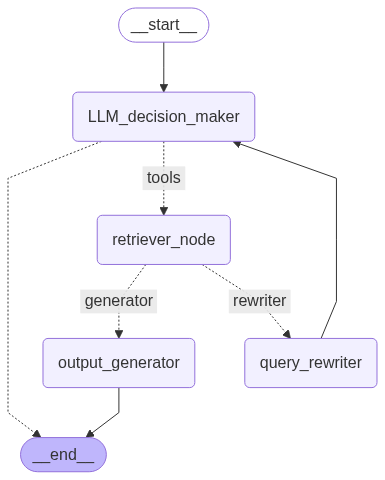

In [37]:
app = workflow.compile()
app

In [46]:
import warnings
warnings.filterwarnings("ignore")
result = app.invoke({"messages":"what is LLM Powered Autonomous Agents explain the planning and reflection and prompt engineering explain me in terms of agents and langchain?"})

--> Call LLM Decision Maker -->
---Done---
--> Grading Documents -->
----DECISION: DOCS ARE RELEVANT----
----Rag Generation----
this is my response:content='LLM Powered Autonomous Agents use Prompt Engineering to communicate with LLM without updating the model weights. Planning involves translating reflections and environmental information into actions for optimizing believability in the moment vs. over time. The agent also utilizes subgoal decomposition and self-reflection for efficient handling of tasks and improving future results.' additional_kwargs={'refusal': None} response_metadata={'token_usage': {'completion_tokens': 62, 'prompt_tokens': 344, 'total_tokens': 406, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'id': 'chatcmpl-BoTVtiV1y8dHwfb1UAnuProl3lIDt', '

In [47]:
result

{'messages': [HumanMessage(content='what is LLM Powered Autonomous Agents explain the planning and reflection and prompt engineering explain me in terms of agents and langchain?', additional_kwargs={}, response_metadata={}, id='3dbfc4dd-2eaa-485e-8739-6664ecd90dbd'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_UuF8pgR8foIYlOsh8GT8cNOY', 'function': {'arguments': '{"query": "LLM Powered Autonomous Agents"}', 'name': 'retriever_blog_post'}, 'type': 'function'}, {'id': 'call_wZIbBYjBaipioPrVlzbrpsm1', 'function': {'arguments': '{"query": "planning and reflection and prompt engineering"}', 'name': 'retriever_blog_post'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 59, 'prompt_tokens': 163, 'total_tokens': 222, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}},

In [48]:
result["messages"][-1].content

'LLM Powered Autonomous Agents use Prompt Engineering to communicate with LLM without updating the model weights. Planning involves translating reflections and environmental information into actions for optimizing believability in the moment vs. over time. The agent also utilizes subgoal decomposition and self-reflection for efficient handling of tasks and improving future results.'